In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [113]:
# Load the CSV file
df = pd.read_csv('combined_data.csv')
df.head(10)

,text,label
0,What is the primary goal of capital budgeting ...,1
1,How do you calculate the weighted average cost...,1
2,Should we accept a project with an IRR of 12% ...,1
3,Can u explain how ncf differs from net income ...,1
4,What is the impact of a 2-for-1 stock split on...,1
5,Discuss the difference between a horizontal an...,1
6,Calculate the cost of equity using CAPM with a...,1
7,What happens to the current ratio if we pay of...,1
8,scenario: company a acquires company b for a 3...,1
9,Why might a firm choose a share buyback over a...,1


In [114]:
# First split: 70% train, 30% temp (for val+test)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    random_state=RANDOM_SEED, 
    stratify=df['label']
)

# Second split: 15% val, 15% test (50-50 split of the 30%)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=RANDOM_SEED, 
    stratify=temp_df['label']
)

print(f"Train size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train size: 2334 (70.0%)
Val size: 500 (15.0%)
Test size: 501 (15.0%)


In [115]:
# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2334
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 501
    })
})

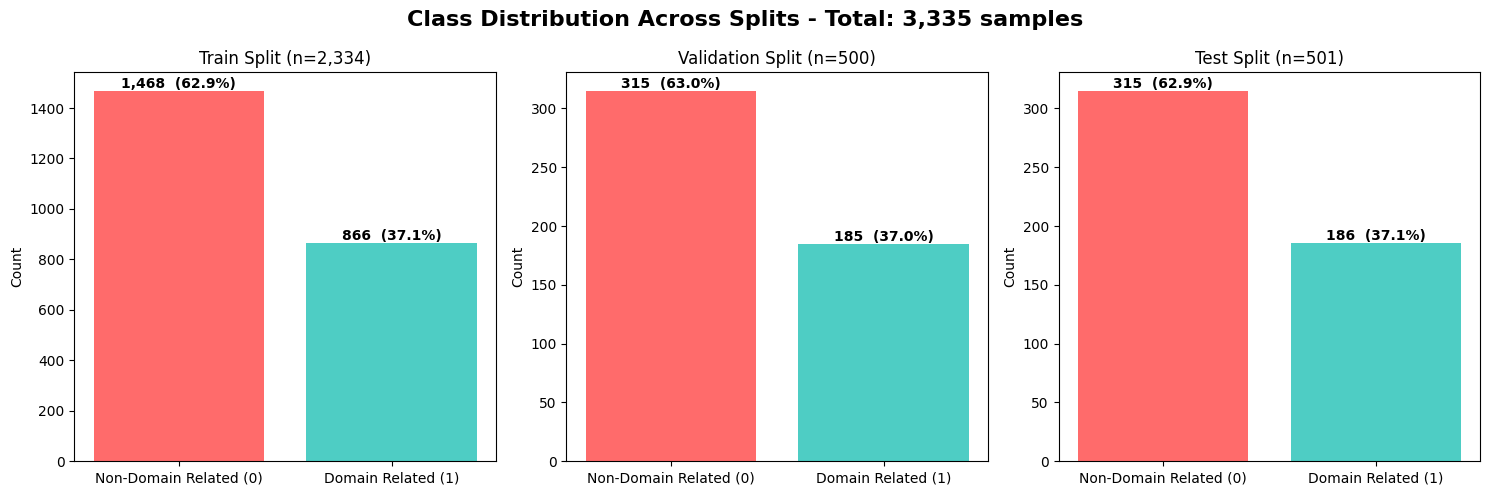

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

splits = [
    ('Train', train_df),
    ('Validation', val_df),
    ('Test', test_df)
]

colors = ['#ff6b6b', '#4ecdc4']  # Red for non-finance, teal for finance

for idx, (split_name, split_df) in enumerate(splits):
    counts = split_df['label'].value_counts().sort_index()
    percentages = (counts / len(split_df) * 100)
    
    bars = axes[idx].bar(['Non-Domain Related (0)', 'Domain Related (1)'], counts.values, color=colors)
    axes[idx].set_title(f'{split_name} Split (n={len(split_df):,})')
    axes[idx].set_ylabel('Count')
    
    # Add count + percentage labels on bars
    for bar, count, pct in zip(bars, counts.values, percentages.values):
        label = f'{count:,}  ({pct:.1f}%)'
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                       label, ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle(f'Class Distribution Across Splits - Total: {len(df):,} samples', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [117]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "answerdotai/ModernBERT-base"

# Label mappings matching the CSV structure
id2label = {0: "non_finance", 1: "finance"}
label2id = {"non_finance": 0, "finance": 1}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

model.config

Loading weights: 100%|██████████| 136/136 [00:00<00:00, 2147.14it/s, Materializing param=model.layers.21.mlp_norm.weight]    
ModernBertForSequenceClassification LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     | 
------------------+------------+-
decoder.bias      | UNEXPECTED | 
classifier.bias   | MISSING    | 
classifier.weight | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


ModernBertConfig {
  "architectures": [
    "ModernBertForMaskedLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 50281,
  "classifier_activation": "gelu",
  "classifier_bias": false,
  "classifier_dropout": 0.0,
  "classifier_pooling": "mean",
  "cls_token_id": 50281,
  "decoder_bias": true,
  "deterministic_flash_attn": false,
  "dtype": "float32",
  "embedding_dropout": 0.0,
  "eos_token_id": 50282,
  "global_attn_every_n_layers": 3,
  "gradient_checkpointing": false,
  "hidden_activation": "gelu",
  "hidden_size": 768,
  "id2label": {
    "0": "non_finance",
    "1": "finance"
  },
  "initializer_cutoff_factor": 2.0,
  "initializer_range": 0.02,
  "intermediate_size": 1152,
  "label2id": {
    "finance": 1,
    "non_finance": 0
  },
  "layer_norm_eps": 1e-05,
  "layer_types": [
    "full_attention",
    "sliding_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "sliding_attention",
    "full_attention",
    "slid

In [118]:
# Freeze all base model parameters (train only classification head)
for param in model.model.parameters():
    param.requires_grad = False

# Verify: count trainable vs frozen parameters
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable: {trainable:,} | Frozen: {frozen:,}")

Trainable: 592,130 | Frozen: 149,014,272


In [ ]:
from transformers import DataCollatorWithPadding

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

tokenized_dataset = dataset_dict.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_dataset

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.special import softmax

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    probs = softmax(logits, axis=-1)
    confidence = np.max(probs, axis=-1)
    
    # Per-class metrics: [non_finance, finance]
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)
    
    # Confidence stats
    correct_mask = preds == labels
    
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision_non_finance": precision[0],
        "recall_non_finance": recall[0],
        "f1_non_finance": f1[0],
        "precision_finance": precision[1],
        "recall_finance": recall[1],
        "f1_finance": f1[1],
        "confidence_mean": confidence.mean(),
        "confidence_correct": confidence[correct_mask].mean() if correct_mask.any() else 0.0,
        "confidence_wrong": confidence[~correct_mask].mean() if (~correct_mask).any() else 0.0,
    }

In [120]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./layer1_model",
    learning_rate=1e-3,
    num_train_epochs=10,  # Reduced from 15 - more data needs fewer epochs
    per_device_train_batch_size=32,  # Increased from 16 - faster training with more data
    per_device_eval_batch_size=64,  # Increased from 32
    weight_decay=0.01,
    warmup_steps=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_finance",
    greater_is_better=True,
    logging_steps=50,  # Increased from 10 - less frequent logging
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
trainer.train()

In [138]:
trainer.evaluate(tokenized_dataset["test"])

/Users/isaacanwar/Desktop/Projects/poison-RAG-gaurdrail/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.7676243185997009,
 'eval_model_preparation_time': 0.0019,
 'eval_accuracy': 0.46511627906976744,
 'eval_precision_non_finance': 0.391304347826087,
 'eval_recall_non_finance': 0.8709677419354839,
 'eval_f1_non_finance': 0.54,
 'eval_precision_finance': 0.7647058823529411,
 'eval_recall_finance': 0.23636363636363636,
 'eval_f1_finance': 0.3611111111111111,
 'eval_confidence_mean': 0.6374413967132568,
 'eval_confidence_correct': 0.638229489326477,
 'eval_confidence_wrong': 0.6367561221122742,
 'eval_runtime': 1.0139,
 'eval_samples_per_second': 84.821,
 'eval_steps_per_second': 1.973}

In [ ]:
# Test your own query
query = "What is the difference between EBITDA and net income?"  # <-- CHANGE THIS

inputs = tokenizer(query, return_tensors="pt", truncation=True, max_length=128)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)[0]

finance_prob = probs[1].item()
prediction = "FINANCE ✓" if finance_prob >= 0.5 else "NON-FINANCE ✗"

print(f"Query: {query}")
print(f"Result: {prediction}")
print(f"Confidence: {max(finance_prob, 1-finance_prob):.1%}")

In [ ]:
import torch

query = ""  # <-- break it buddy

inputs = tokenizer(query, return_tensors="pt", truncation=True, max_length=128)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)[0]

finance_prob = probs[1].item()
prediction = "✅ You Chillin ✅" if finance_prob >= 0.5 else "❌❌ BLOCKED ❌❌"

print(f"Query: {query}")
print(f"Result: {prediction}")
print(f"Confidence: {max(finance_prob, 1-finance_prob):.1%}")

Query: does it go in debit or credit
Result: ✅ You Chillin ✅
Confidence: 56.9%
